# Prequisites

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader
import torch
import time
from tqdm.notebook import tqdm
from tempfile import TemporaryDirectory
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter # For tensorboard support

## Dataset Creation

In [2]:
main_dir = "raw-img"
dic = {}

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    count = len(os.listdir(img_folder))
    dic[i] = count

<BarContainer object of 10 artists>

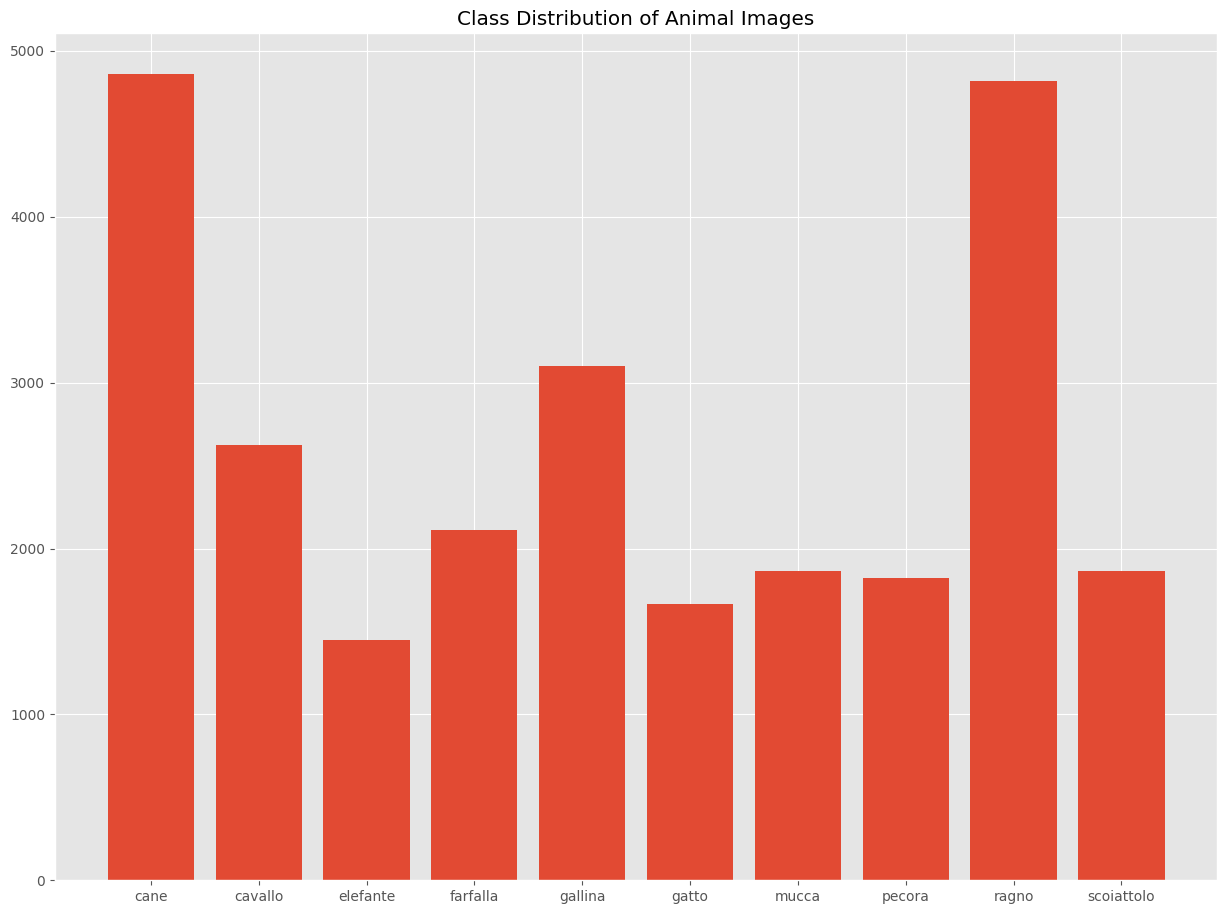

In [3]:
x = list(dic.keys())
y = list(dic.values())
plt.figure(figsize=(15, 11)) #Width , height
plt.title("Class Distribution of Animal Images")
plt.bar(x, y)

In [4]:
#Creating encoded labels for the animals 

animal_key = {}
count = 0 
main_dir = "raw-img"

for i in os.listdir(main_dir):
    animal_key[i] = count
    count += 1 
animal_key

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [5]:
#Creating a csv with image paths before using our custom data loader

main_dir = "raw-img" 
img_paths = []
labels = []

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    for j in os.listdir(img_folder):
        img_path = os.path.join(img_folder, j)
        img_paths.append(img_path)
        labels.append(animal_key[i])

data = pd.DataFrame([img_paths, labels])
data = data.transpose()
data.to_csv("info.csv", index=None)

In [6]:
class CustomDatasetLoader(Dataset):
    def __init__(self, csv_path, transform=None): #Init function runs only once when instantiating the Dataset object
        self.img_info = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self): #Returns the total number of data points
        return len(self.img_info)

    def __getitem__(self, index): #Should return the image and label from the data source as per the "index" value iterated over the length
        img_path = self.img_info.iloc[index, 0]
        img = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_info.iloc[index, 1]
        if self.transform:
            img = self.transform(img)
        return img, label 

In [158]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
#The values for normalization and standardization are given as per the recommended values from https://pytorch.org/vision/0.9/models.html

In [159]:
train_data = CustomDatasetLoader("info.csv", train_transform)
test_data = CustomDatasetLoader("info.csv", test_transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_data, shuffle=True, batch_size=128)

# Basic Transfer Learning

Fixed Feature Extractor

All the layers are frozen except for the last classification layer/s which is also modified as the number of classes prediction has to be same as our use case

In [30]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)

C:\Users\Snowwolf\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Snowwolf\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
for parameter in model.parameters():
    parameter.requires_grad = False #the .requires_grad=True by default for all layers

model.classifier[-1] = torch.nn.Linear(1024, 10) #We have 10 classes in our data

for i in model.classifier.parameters():
    i.requires_grad = True 

In [32]:
#Defining device 

if torch.cuda.is_available():
    print("GPU Available")
    device = torch.device("cuda")
else:
    print("Device is CPU")
    device = torch.device("cpu")

model = model.to(device)

GPU Available


In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Decay LR by a factor of 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [34]:
#timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter("runs/classifier_{}".format(timestamp))


training_accuracy_list = []
training_loss_list = []
length = []

def model_training(total_epochs, optimizer, criterion, model, device):
    counter= 0
    for epoch in range(total_epochs):
        print(f"Epoch :{epoch}")

        #Make model trainable | Gradien tracking is on 
        model.train()
        #One pass over data
        running_loss = 0.
        running_accuracy = 0.
        total_samples = 0.

        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad() #Zero the gradients for every batch
            outputs = model(inputs) #Predictions for this batch
            loss = criterion(outputs, targets) #Computer loss and its gradients
            loss.backward()
            optimizer.step() #Adjust learning weights 
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Assuming classification
            running_accuracy += torch.sum(preds == targets).item()
            total_samples += inputs.size(0)

        training_accuracy_result = running_accuracy / total_samples
        training_accuracy_list.append(training_accuracy_result)
        loss_result = float(running_loss / total_samples)
        training_loss_list.append(loss_result)
        length.append(counter)
        counter += 1
        print(f"For Batch size {len(i)} images\nLoss ={loss_result}") 
        print(f"Training Accuracy : {training_accuracy_result}")
    return model 


In [35]:
a = time.time()
model = model_training(15, optimizer, criterion, model, device)
print("Total training time is {} seconds".format(time.time()-a))

Epoch :0


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.01691504262968055
Training Accuracy : 0.6642346919286451
Epoch :1


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.011468170291759363
Training Accuracy : 0.7611826272966882
Epoch :2


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.010586086547494485
Training Accuracy : 0.7745903204858856
Epoch :3


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.010139703296955687
Training Accuracy : 0.784369150846098
Epoch :4


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.0098383636428891
Training Accuracy : 0.7877688223385156
Epoch :5


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.009533897306953797
Training Accuracy : 0.7955231292257152
Epoch :6


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.009373436277756657
Training Accuracy : 0.7980442339279575
Epoch :7


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.009435845952997726
Training Accuracy : 0.7983880209328087
Epoch :8


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.009071428676677755
Training Accuracy : 0.8032010390007258
Epoch :9


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008975580754165885
Training Accuracy : 0.8033920317811987
Epoch :10


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008939879523172769
Training Accuracy : 0.8070590931662783
Epoch :11


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008873602131128975
Training Accuracy : 0.806638909049238
Epoch :12


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008789727053424973
Training Accuracy : 0.8088926238588181
Epoch :13


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008624677082457606
Training Accuracy : 0.8154627755070858
Epoch :14


  0%|          | 0/410 [00:00<?, ?it/s]

For Batch size 10 images
Loss =0.008533297015764645
Training Accuracy : 0.8156919668436533
Total training time is 752.2881920337677 seconds


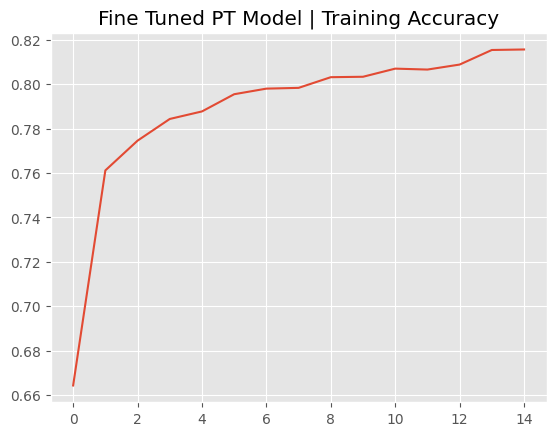

In [37]:
plt.title("Fine Tuned PT Model | Training Accuracy")
plt.plot(length, training_accuracy_list)

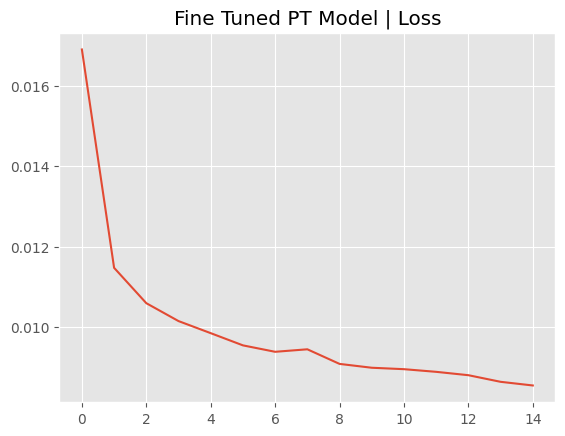

In [38]:
plt.title("Fine Tuned PT Model | Loss")
plt.plot(length, training_loss_list)

In [39]:
torch.save(model, "finetuned.pth") #Saveing with structure of class together with the model

In [44]:
with open("results/finetune.txt", "w") as file:
    file.write("Training Accuracy" +"\t" + "Loss Values" + "\n")
    for index, i in enumerate(length):
        file.write(str(training_accuracy_list[index]) + "\t" + str(training_loss_list[index]) + "\n")

In [52]:
#Count total number of parameters in PyTorch Model
sum = 0
for layer in model.parameters():
    sum += layer.numel()

print("Total number of parameters are ", sum)

Total number of parameters are  1528106


In [102]:
#Inferencing 

img_path = "raw-img\scoiattolo\OIP-zzy5kEbHuGBWXZ3c-D85aAHaE8.jpeg"
img = read_image(img_path, mode=ImageReadMode.RGB)
img = torchvision.transforms.Resize((128,128))(img)
img = img.unsqueeze(0)
img = img.to(device).float()
print("shape of image is ", img.shape)

model.eval()
model = model.to(device)
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

#preds[0].cpu().item()
preds

shape of image is  torch.Size([1, 3, 128, 128])


tensor([7], device='cuda:0')

In [104]:
x = torch.rand((212,3,128,128)).to(device).float()
x.size()
model.eval()
model = model.to(device)
with torch.no_grad():
    outputs = model(x)
    _, preds = torch.max(outputs, 1)

In [110]:
#GPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256, 512, 1024, 2048]
ts = []

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

ts

[0.006001710891723633,
 0.006001472473144531,
 0.007672786712646484,
 0.0066738128662109375,
 0.006001472473144531,
 0.00500178337097168,
 0.004981040954589844,
 0.059600830078125,
 0.0650169849395752]

In [153]:
#CPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256, 512, 1024, 2048]
ts = []
device = torch.device("cpu")
model.eval().to(device)

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

ts

[0.010002374649047852,
 0.10602378845214844,
 0.06701445579528809,
 0.09102058410644531,
 0.1888258457183838,
 0.38608574867248535,
 0.7720434665679932,
 1.5221967697143555,
 3.3791754245758057]

In [161]:
#Soft Evaluation 

device = torch.device("cpu")
model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/205 [00:00<?, ?it/s]

0.8465564001680737


# Dynamic Quantization

In [144]:
model = torch.load("finetuned.pth")

In [150]:
import torch.quantization as quant

model.eval().to(device="cpu")

quantized_model = quant.quantize_dynamic(model, 
                                         {torch.nn.Linear}, 
                                         dtype=torch.qint8)

In [151]:
torch.save(quantized_model, "int8_dynamic_quantization.pth")
#From 5.99 MB to 4.27 MB
#around 30% reduction in memory footprint

In [152]:
batch_sizes = [1, 8, 32, 64, 128, 256, 512, 1024, 2048]
ts = []


with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).float()
        a = time.time()
        outputs = quantized_model(x)
        ts.append(time.time()-a)

ts

[0.01700305938720703,
 0.03300762176513672,
 0.05701255798339844,
 0.10229969024658203,
 0.20174193382263184,
 0.40709996223449707,
 0.8072922229766846,
 1.6108405590057373,
 3.156827926635742]

I tried to run on GPU but for X86 system and the current version of the library the support for these opearators are not there for Int8

In [156]:
#Tensor comparison 

data, targets = next(iter(train_loader))

data = data.to(device="cpu")

original_output = model(data)
quantized_output = quantized_model(data)
comparison = torch.allclose(original_output, quantized_output, atol=1e-1)
comparison

False

In [162]:
device = torch.device("cpu")
quantized_model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = quantized_model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/205 [00:00<?, ?it/s]

0.8457160319339929
